# Image Super Resolution using Deep Learning

Author: Dominik Chodounský, Faculty of Information Technology, CTU in Prague

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.applications import VGG19
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, display
import cv2
import pandas as pd
import imageio as iio
from tqdm import tqdm
import os
import random
import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import *
from unet import *
from srgan import *

## Data setup

In [3]:
img_size = 64
target_size = 128
batch_size = 4
rand_seed = 42
train_dir = os.path.join('../', 'data', 'vimeo', 'train_paths.txt')
test_dir = os.path.join('../', 'data', 'vimeo', 'test_paths.txt')
save_dir = os.path.join('../', 'models')

np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)
random.seed(rand_seed)
os.environ['PYTHONHASHSEED'] = str(rand_seed)

warnings.filterwarnings("ignore")

In [4]:
train_list = []
with open(train_dir, 'r') as f:
    for line in f.readlines():
        train_list.append(line)
        
test_list = []
with open(test_dir, 'r') as f:
    for line in f.readlines():
        test_list.append(line)

In [5]:
print('Training:', len(train_list), 'septuplet sequences  |  Test images:', len(test_list), 'septuplet seqeunces')

Training: 7041 septuplet sequences  |  Test images: 783 septuplet seqeunces


In [6]:
# Perceptual loss function 

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output, name='VGG_loss')

# make the net not trainable
for layer in vgg_layer.layers: 
    layer.trainable = False 

print(vgg_layer.summary())

def perceptual_loss(y_true, y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=mean_squared_error(y_t, y_p)
    return loss

Model: "VGG_loss"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

## SR-U-Net

In [7]:
unet = unet(img_size)
unet.summary()

Model: "SR-U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Training

In [8]:
model_save = os.path.join(save_dir, 'vimeo_SRUNET_perceptual_64_to_128' + '.h5')

# callback for early stopping regularization
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# callback for continuous checkpointing of best model configuration
checkpointing = callbacks.ModelCheckpoint(
    filepath=model_save,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [9]:
train_gen = generator_vimeo(train_list, img_size, target_size, batch_size)

In [11]:
unet.compile(optimizer=Adam(learning_rate=0.001),
              #loss=psnr_loss,
              loss=perceptual_loss, #MeanSquaredError(),
              metrics=[psnr, ssim, MeanSquaredError()])

history = unet.fit(x=train_gen,
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping, checkpointing])

Epoch 1/30
1761/1761 [==============================] - ETA: 0s - loss: 2.1732 - psnr: 12.0930 - ssim: 0.4451 - mean_squared_error: 0.1307
Epoch 00001: loss improved from 4.67629 to 2.17319, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 475s 270ms/step - loss: 2.1732 - psnr: 12.0930 - ssim: 0.4451 - mean_squared_error: 0.1307
Epoch 2/30
1761/1761 [==============================] - ETA: 0s - loss: 1.8104 - psnr: 13.6671 - ssim: 0.4788 - mean_squared_error: 0.1096
Epoch 00002: loss improved from 2.17319 to 1.81038, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 480s 273ms/step - loss: 1.8104 - psnr: 13.6671 - ssim: 0.4788 - mean_squared_error: 0.1096
Epoch 3/30
1761/1761 [==============================] - ETA: 0s - loss: 1.5598 - psnr: 14.2443 - ssim: 0.4862 - mean_squared_error: 0.0915
Epoch 00003: loss improved from 1.81038 to 1.55979, saving model to ../models\vim

Epoch 23/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6871 - psnr: 17.6031 - ssim: 0.5141 - mean_squared_error: 0.0621
Epoch 00023: loss improved from 0.69961 to 0.68713, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 465s 264ms/step - loss: 0.6871 - psnr: 17.6031 - ssim: 0.5141 - mean_squared_error: 0.0621
Epoch 24/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6520 - psnr: 18.0906 - ssim: 0.5182 - mean_squared_error: 0.0604
Epoch 00024: loss improved from 0.68713 to 0.65196, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 465s 264ms/step - loss: 0.6520 - psnr: 18.0906 - ssim: 0.5182 - mean_squared_error: 0.0604
Epoch 25/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6641 - psnr: 18.2251 - ssim: 0.5253 - mean_squared_error: 0.0586
Epoch 00025: loss did not improve from 0.65196
1761/1761 [====================

### Image evaluation

In [12]:
unet = tf.keras.models.load_model(os.path.join(save_dir, 'vimeo_SRUNET_64_to_128.h5'), compile=False)

In [13]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)

In [14]:
get_stats(unet, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [06:59<00:00,  1.87it/s]


MSE: 0.0021393818
PSNR: 27.923904
SSIM: 0.8996612


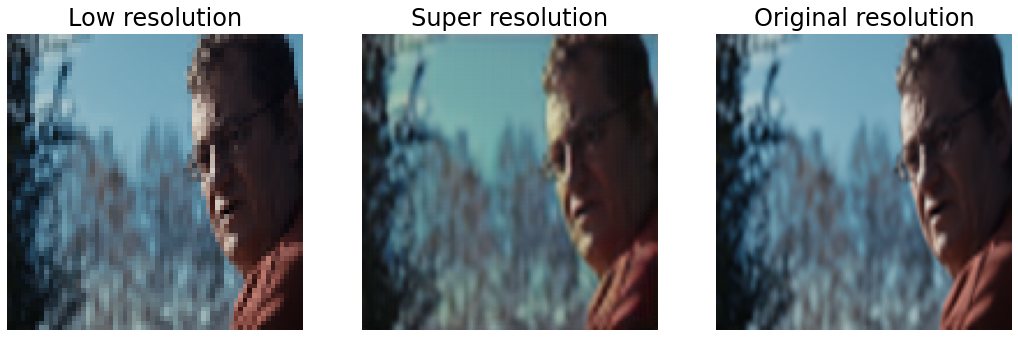

In [44]:
plot_comparison(unet, test_gen)

### Video evaluation

In [16]:
vid_name, ext = 'street', 'mp4'
reader = iio.get_reader('../data/' + vid_name + '.' + ext)
hr_frames = []
lr_frames = []
frames=[]
for i, im in enumerate(reader):
    hr_img = np.array(cv2.resize(im, (target_size, target_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    hr_frames.append(np.array(hr_img, np.float32)/255.)
    
    lr_img = np.array(cv2.resize(im, (img_size, img_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    lr_frames.append(np.array(lr_img, np.float32)/255.)

In [17]:
get_video_stats(unet, lr_frames, hr_frames)

304it [00:19, 15.32it/s]


MSE: 0.021373864
PSNR: 16.91301
SSIM: 0.5177287


In [18]:
sr_frames = []
for lr in lr_frames:
    sr = unet.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(sr)
sr_frames = np.squeeze(np.array(sr_frames))

In [19]:
%%capture
iio.mimsave('../data/lr_' + vid_name + '.gif', lr_frames, fps=24)
iio.mimsave('../data/sr_' + vid_name + '.gif', sr_frames, fps=24)
iio.mimsave('../data/hr_' + vid_name + '.gif', hr_frames, fps=24)

In [20]:
plot_video_comparison('../data/lr_' + vid_name + '.gif', '../data/sr_' + vid_name + '.gif', '../data/hr_' + vid_name + '.gif')

,,


## SR-GAN

### Training

In [21]:
train_gan(img_size=img_size, target_size=target_size, epochs=10, batch_size=batch_size, batch_cnt=int(len(train_list) / batch_size),
          train_gen=generator_vimeo(train_list, img_size, target_size, 1), loss=perceptual_loss, save_dir=save_dir,
          desc='vimeo_perceptual')

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:19<00:00,  1.31it/s]


discriminator_loss : 0.400745
gan_loss : [0.004244138486683369, 0.002809100551530719, 1.4350378513336182]
--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [23:25<00:00,  1.25it/s]


discriminator_loss : 0.316370
gan_loss : [0.01853344216942787, 0.0175030380487442, 1.0304042100906372]
--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [26:26<00:00,  1.11it/s]


discriminator_loss : 0.285514
gan_loss : [0.003393706399947405, 0.00291927857324481, 0.47442784905433655]
--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [25:09<00:00,  1.17it/s]


discriminator_loss : 0.314213
gan_loss : [0.0023000852670520544, 0.0020306867081671953, 0.26939857006073]
--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:36<00:00,  1.30it/s]


discriminator_loss : 0.315667
gan_loss : [0.002080858452245593, 0.001407196861691773, 0.6736615300178528]
--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:20<00:00,  1.31it/s]


discriminator_loss : 0.307310
gan_loss : [0.0008885195711627603, 0.000588269904255867, 0.3002496361732483]
--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:35<00:00,  1.30it/s]


discriminator_loss : 0.404854
gan_loss : [0.0019510078709572554, 0.0008671614923514426, 1.0838463306427002]
--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:24<00:00,  1.31it/s]


discriminator_loss : 0.267619
gan_loss : [0.0010298513807356358, 0.0002994011156260967, 0.7304502725601196]
--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:32<00:00,  1.30it/s]


discriminator_loss : 0.349307
gan_loss : [0.0010719221318140626, 0.0004182464617770165, 0.6536756157875061]
--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [22:25<00:00,  1.31it/s]


discriminator_loss : 0.328719
gan_loss : [0.0009699049405753613, 0.0006304937414824963, 0.339411199092865]


### Evaluation

In [22]:
G = tf.keras.models.load_model(os.path.join(save_dir, './gan_vimeo/catdogs_G_64_to_128__10.h5'))
G.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_17 (PReLU)              (None, 64, 64, 64)   64          conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_17[0][0]                 
_______________________________________________________________________________________

In [23]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)
get_stats(G, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [06:50<00:00,  1.91it/s]


MSE: 0.005019718
PSNR: 29.968336
SSIM: 0.9163146


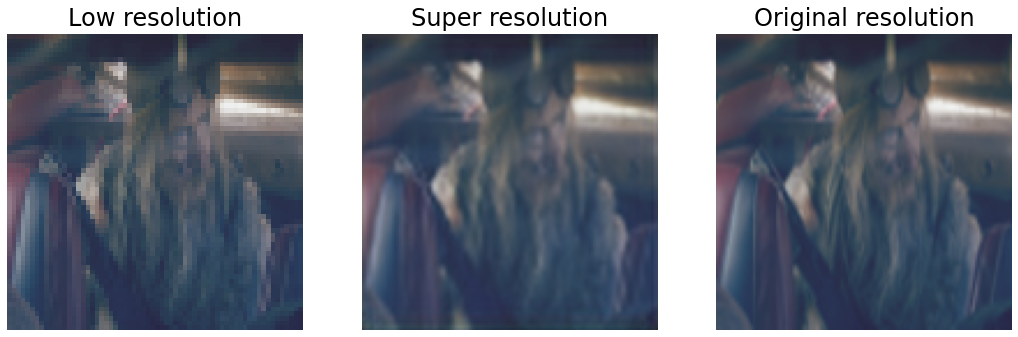

In [24]:
plot_comparison(G, test_gen)

In [25]:
get_video_stats(G, lr_frames, hr_frames)

304it [00:19, 15.96it/s]


MSE: 0.027356198
PSNR: 15.926112
SSIM: 0.5150625


In [26]:
sr_frames = []
for lr in lr_frames:
    hr = G.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(hr)
sr_frames = np.squeeze(np.array(sr_frames))

In [27]:
iio.mimsave('../data/lr_' + vid_name + '.gif', np.uint8(lr_frames), fps=24)
iio.mimsave('../data/sr_' + vid_name + '.gif', np.uint8(sr_frames), fps=24)
iio.mimsave('../data/hr_' + vid_name + '.gif', np.uint8(hr_frames), fps=24)

In [28]:
plot_video_comparison('../data/lr_' + vid_name + '.gif', '../data/sr_' + vid_name + '.gif', '../data/hr_' + vid_name + '.gif')

,,
